In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/MyDrive/clue"

Mounted at /gdrive
/gdrive/MyDrive/clue


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# Other constants
DATASET_DIR = "./"
DATA_FILENAME = "extended_dataset.csv"

dataframe = pd.read_csv(f"{DATASET_DIR}{DATA_FILENAME}")
dataframe.sample(5)

,GAME_ID,W_PCT_home,HOME_RECORD_home,ROAD_RECORD_home,W_PCT_prev_home,HOME_RECORD_prev_home,ROAD_RECORD_prev_home,W_PCT_away,HOME_RECORD_away,ROAD_RECORD_away,W_PCT_prev_away,HOME_RECORD_prev_away,ROAD_RECORD_prev_away,WIN_PRCT_home_3g,PTS_home_3g,FG_PCT_home_3g,FT_PCT_home_3g,FG3_PCT_home_3g,AST_home_3g,REB_home_3g,WIN_PRCT_away_3g,PTS_away_3g,FG_PCT_away_3g,FT_PCT_away_3g,FG3_PCT_away_3g,AST_away_3g,REB_away_3g,WIN_PRCT_home_20g,PTS_home_20g,FG_PCT_home_20g,FT_PCT_home_20g,FG3_PCT_home_20g,AST_home_20g,REB_home_20g,WIN_PRCT_away_20g,PTS_away_20g,FG_PCT_away_20g,FT_PCT_away_20g,FG3_PCT_away_20g,AST_away_20g,REB_away_20g,SEASON,HOME_TEAM_WINS
18432,21600416,0.269,0.230769,0.307692,0.354,0.341463,0.365854,0.296,0.333333,0.266667,0.280,0.341463,0.219512,0.333333,105.333333,0.444000,0.754667,0.331333,23.333333,51.333333,0.333333,102.000000,0.414000,0.792000,0.344667,14.666667,46.333333,0.30,104.20,0.4523,0.78595,0.32515,22.55,43.20,0.30,106.50,0.44285,0.77320,0.35125,18.35,44.80,2016,1
11459,21100375,0.200,0.285714,0.090909,0.280,0.487805,0.073171,0.400,0.461538,0.333333,0.512,0.560976,0.463415,0.333333,93.666667,0.414000,0.687000,0.328333,14.666667,36.666667,0.666667,95.666667,0.450000,0.795667,0.221333,19.333333,41.000000,0.25,91.15,0.4267,0.71190,0.29435,18.05,42.20,0.40,95.55,0.43435,0.77565,0.28615,19.35,43.20,2011,0
290,20300321,0.292,0.400000,0.214286,0.427,0.634146,0.219512,0.130,0.076923,0.200000,0.512,0.634146,0.390244,0.333333,98.000000,0.475000,0.767000,0.285667,26.333333,45.000000,0.666667,98.333333,0.423667,0.887667,0.460000,21.666667,42.666667,0.30,91.25,0.4412,0.79195,0.28050,20.20,43.10,0.10,90.40,0.41510,0.74070,0.35285,17.95,41.65,2003,0
15733,21400629,0.381,0.285714,0.476190,0.354,0.414634,0.292683,0.341,0.263158,0.400000,0.280,0.463415,0.097561,0.666667,95.666667,0.387333,0.764667,0.368333,20.333333,52.333333,0.333333,105.000000,0.447667,0.804333,0.356333,20.666667,37.000000,0.65,102.65,0.4457,0.69615,0.35595,22.55,47.05,0.30,95.30,0.45020,0.73130,0.35820,21.05,39.05,2014,1
738,20300770,0.574,0.714286,0.423077,0.207,0.317073,0.097561,0.415,0.481481,0.346154,0.585,0.609756,0.560976,0.666667,95.000000,0.453667,0.743333,0.421333,21.000000,41.000000,0.333333,93.333333,0.438333,0.743667,0.215667,21.000000,41.666667,0.55,96.40,0.4662,0.76565,0.30100,22.25,40.95,0.35,90.55,0.43365,0.74265,0.29335,19.55,43.95,2003,1


42 2 ['NO', 'YES']


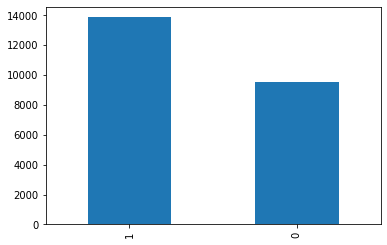

In [23]:
TARGET="HOME_TEAM_WINS"
input_size=len(dataframe.columns)-1
classes  = ["NO", "YES"]
output_size=len(classes)
print(input_size,  output_size,  classes)

target = dataframe[TARGET].value_counts()
target.plot(kind="bar")

In [24]:
# Remove rows with nan values
initial_len =  len(dataframe)
dataframe.dropna(inplace=True)
print(f"{len(dataframe)}/{initial_len}")

dataframe.info()

23279/23376
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23279 entries, 1 to 23375
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GAME_ID                23279 non-null  int64  
 1   W_PCT_home             23279 non-null  float64
 2   HOME_RECORD_home       23279 non-null  float64
 3   ROAD_RECORD_home       23279 non-null  float64
 4   W_PCT_prev_home        23279 non-null  float64
 5   HOME_RECORD_prev_home  23279 non-null  float64
 6   ROAD_RECORD_prev_home  23279 non-null  float64
 7   W_PCT_away             23279 non-null  float64
 8   HOME_RECORD_away       23279 non-null  float64
 9   ROAD_RECORD_away       23279 non-null  float64
 10  W_PCT_prev_away        23279 non-null  float64
 11  HOME_RECORD_prev_away  23279 non-null  float64
 12  ROAD_RECORD_prev_away  23279 non-null  float64
 13  WIN_PRCT_home_3g       23279 non-null  float64
 14  PTS_home_3g            23279 non-null  flo

19788/23376


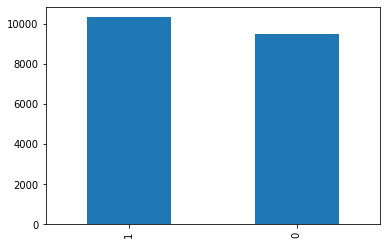

In [25]:
# Balance data

min_count = min(target.values)
max_count  = max(target.values)
remove_n = int((max_count -min_count) * 0.8)
temp = dataframe[dataframe[TARGET]==1]
drop_indices = np.random.choice(temp.index, remove_n, replace=False)

dataframe = dataframe.drop(drop_indices)

num_rows= len(dataframe)
print(f"{num_rows}/{initial_len}")

target = dataframe[TARGET].value_counts()
target.plot(kind="bar")

In [26]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop([TARGET, "GAME_ID"], axis=1).values

targets = dataframe[[TARGET]].values
targets =  np.reshape(targets, len(targets))

inputs.shape, targets.shape

((19788, 41), (19788,))

In [27]:
# metrics and validations techniques
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_recall_fscore_support

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler


# classifiers from sklearn example
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# classifiers from laila project
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

# classifiers from sklearn example
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import NearestCentroid

from time import time, gmtime


In [28]:
IMAGES_PATH=  "./"
def benchmark_report(clf, x_train, y_train, x_test, y_test, target_names=None, features_name=None):
    t0 = time()
    clf.fit(x_train, y_train)
    train_time = time() - t0

    t0 = time()
    pred = clf.predict(x_test)
    pred_proba = clf.predict_proba(x_test)
    test_time = time() - t0

    score = metrics.accuracy_score(y_test, pred)
    rept = precision_recall_fscore_support(y_test, pred, average='weighted')

    return (rept[0], rept[1], rept[2], train_time, test_time), pred_proba     # is returning  presicion, recall, f1 score, and training and test times

def plot_classifier_comparison(clfs_dict, experiment_name=None):
    clf_names = clfs_dict.keys()
    indices = np.arange(len(clf_names))
    pres, rec, f1, train_time, test_time = [
        [clfs_dict[k]['results']['mean'][i] for k in clf_names] for i in range(5)]

    train_time = np.array(train_time) / np.max(train_time)
    test_time = np.array(test_time) / np.max(test_time)
    
    comp_figure = plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.grid()

    plt.title("Classifiers Comparison Metrics")
    plt.barh(indices, pres, .1, label="precision", color='blue')
    plt.barh(indices+.1, rec, .1, label="recall", color='red')
    plt.barh(indices+.2, f1, .1, label="f1", color='green')

    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.subplot(1, 2, 2)
    plt.grid()

    plt.title("Classifiers Comparison Times")

    plt.barh(indices+.3, train_time, .1, label="training time",color='orange')
    plt.barh(indices+.4, test_time, .1, label="test time (batch)", color='darkorange')
    
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    plt.tight_layout()
    a = gmtime(time())
    date = str.format('{0}{1}{2}', a.tm_year, a.tm_mon, a.tm_mday)
    name = str.format('{0}{1} {2}.png',IMAGES_PATH, date, experiment_name if experiment_name else 'classifier_comparison')
    plt.savefig(name)
    plt.show()

def resume_report(kfold_metrics, verbose=True):
    means = np.mean(kfold_metrics, axis=0)
    stds = np.std(kfold_metrics, axis=0)
    resume = {'mean': means, 'std': stds }
    if verbose:
        print('_' * 80)
        print("train time: %0.3fs , %0.3fs" % (means[3], stds[3]) )
        print("test time:  %0.3fs, %0.3fs" % (means[4], stds[4]))
        print("precision:   %0.3f, %0.3fs" % (means[0], stds[0]))
        print("recall:   %0.3f, %0.3fs" % (means[1], stds[1]))
        print("fbeta_score:   %0.3f, %0.3fs" % (means[2], stds[2]))
    return resume

In [29]:
def classifier_comparison(clf_dict, X=None, Y=None, k_fold_splits=3, plot=True, verbose=True, tag=None):
    '''
    
    '''
    kf = KFold(n_splits=k_fold_splits, shuffle=True, random_state=42)

    for i, name in enumerate(clf_dict.keys()):
        clf = clf_dict[name]['f']
        if verbose:
            print('=' * 80)
            print(name)
            print(clf)
            print('_' * 80)

        clf_dict[name]['results'] = []
        clf_dict[name]['predicts_proba'] = []
        
        for i, (train, test) in enumerate(kf.split(X, Y)):

            X_train = X[train]
            y_train = Y[train]
            X_test =  X[test]
            y_test = Y[test]

            if verbose:
                print(str.format(f'---> kfold {i}: train_samples: {X_train.shape[0]}, test_samples:{X_test.shape[0]},  n_features: {X_train.shape[1]}'))
            
            benchmark, predict_proba  = benchmark_report(clf, X_train, y_train, X_test, y_test)
            
            clf_dict[name]['results'].append(list(benchmark))
            clf_dict[name]['predicts_proba'].append(predict_proba)

        clf_dict[name]['results'] = resume_report(clf_dict[name]['results'], verbose=verbose)
    return  clf_dict

    

In [30]:
clfs = {
    "Naive Bayes - Bernoulli":{
         'f' : BernoulliNB()},
    
    "Nearest Neighbors" :{
         'f' : KNeighborsClassifier(3)} ,
    
    "Decision Tree":{
         'f' : DecisionTreeClassifier(max_depth=5)},
    
    "Random Forest":{ 
         'f' : RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)},
    
    "Neural Net":{ 
         'f' :MLPClassifier(alpha=1) },
    
    "AdaBoost":{ 
         'f' :  AdaBoostClassifier()},
    
    "Stratified Gradient Descent - log":{ 
         'f' : SGDClassifier(loss='log', penalty='elasticnet')},

    "Stratified Gradient Descent - modified_huber":{ 
         'f' : SGDClassifier(loss='modified_huber', penalty='l1')},
}

In [31]:
resume_dict=  classifier_comparison(clfs, X=inputs, Y=targets, verbose=True, tag="Test1")


Naive Bayes - Bernoulli
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
________________________________________________________________________________
---> kfold 0: train_samples: 13192, test_samples:6596,  n_features: 41
---> kfold 1: train_samples: 13192, test_samples:6596,  n_features: 41
---> kfold 2: train_samples: 13192, test_samples:6596,  n_features: 41
________________________________________________________________________________
train time: 0.010s , 0.000s
test time:  0.009s, 0.000s
precision:   0.569, 0.005s
recall:   0.556, 0.004s
fbeta_score:   0.506, 0.001s
Nearest Neighbors
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
________________________________________________________________________________
---> kfold 0: train_samples: 13192, test_samples:6596,  n_features: 41
---> kfold 1: train_samples: 13192, te

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________________________________________________________________________
train time: 0.725s , 0.075s
test time:  0.004s, 0.001s
precision:   0.504, 0.172s
recall:   0.525, 0.011s
fbeta_score:   0.370, 0.020s
Stratified Gradient Descent - modified_huber
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
________________________________________________________________________________
---> kfold 0: train_samples: 13192, test_samples:6596,  n_features: 41
---> kfold 1: train_samples: 13192, test_samples:6596,  n_features: 41
---> kfold 2: train_samples: 13192, test_samples:6596,  n_features: 41
____________

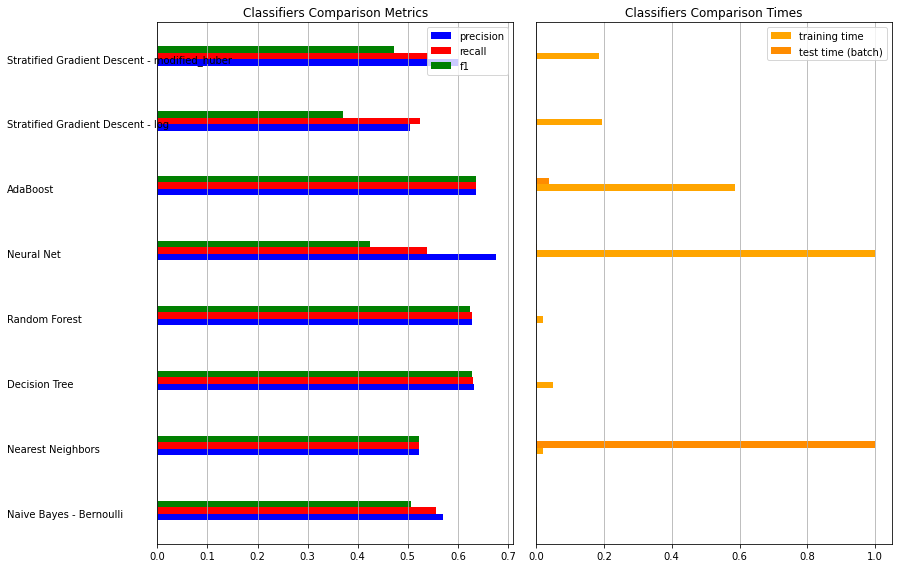

In [36]:
plot_classifier_comparison(resume_dict, experiment_name="Test1")

In [38]:
val_percent = .15 
val_size = int(len(inputs) * val_percent)
train_size = num_rows - val_size

In [39]:
clf = clfs['AdaBoost']['f']
x_train = inputs[0:train_size]
y_train = targets[0:train_size]

x_test = inputs[train_size:len(inputs)]
y_test = targets[train_size:len(inputs)]

benchmark, predict_proba = benchmark_report(clf, x_train, y_train, x_test, y_test)
resume_report([benchmark], verbose=True)

________________________________________________________________________________
train time: 2.614s , 0.000s
test time:  0.081s, 0.000s
precision:   0.632, 0.000s
recall:   0.630, 0.000s
fbeta_score:   0.629, 0.000s


{'mean': array([0.63238541, 0.62971698, 0.62874453, 2.61395121, 0.08104634]),
 'std': array([0., 0., 0., 0., 0.])}

In [40]:
import joblib
# now you can save it to a file
joblib.dump(clf, 'nba_sklearn_model.pkl') 

# and later you can load it
clf = joblib.load('nba_sklearn_model.pkl')

In [41]:
def predict_single(input, label):
  prediction =  clf.predict([input])
  print(f"label: {label}")
  print(f"prediction: {prediction}")

In [44]:
index=499
target = targets[index]
input = inputs[index]
predict_single(input,target)

label: 1
prediction: [1]
